## Battle of the Boosters: Comparing Gradient Boosting Libraries XGBoost and CatBoost

Over the past couple of years, boosting methods have become extremely popular in data scientist circles due to their effectiveness at accurately predicting values. Currently the most popular software library for boosting methods is XGBoost however, there are new boosting libraries being produced all of the time which claim to be superior to XGBoost in different ways. In this project I'll compare XGBoost with a new library called 'CatBoost', which has quickly become popular in Kaggle competitions. Using these methods in my official Kaggle competition submission has me currently in the top 20% in the leaderboard. The outline of this project is as follows:


[About the Data](#About_the_Data)

[1. Exploratory Data Analysis](#Exploratory_Data_Analysis)
- [1.1 Outlier Detection](#Outlier_Detection)
- [1.2 Feature correlations](#Feature_correlations)

[2. Evaluation Metric](#Evaluation_Metric)

[3. XGBoost](#XGBoost)
* [3.1 Train-Test split](#Train_Test_split)
* [3.2 GridSearch bandgap_energy_ev](#GridSearch_bandgap_energy_ev)
* [3.3 GridSearch formation_energy_ev_natom](#GridSearch_formation_energy_ev_natom)
* [3.4 XGBoost Results](#XGBoost_Results)

[4. CatBoost](#CatBoost)
* [4.1 Train-Test split](#Train_Test_split2)
* [4.2 GridSearch bandgap_energy_ev](#GridSearch_bandgap_energy_ev2)
* [4.3 GridSearch formation_energy_ev_natom](#GridSearch_formation_energy_ev_natom2)
* [4.4 CatBoost Results](#CatBoost_Results)

[5. Summary and Future work](#Summary)

<a id=’About_the_Data’></a>
## About the Data

Transparent conductors are an important class of compounds that are both electrically conductive and have a low absorption in the visible range, which are typically competing properties. 

predict two target variables: the formation energy (which is an indication of the stability of a new material) and the bandgap energy (which is an indication of the potential for transparency over the visible range). A link to more information about the dataset can be found [here](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors).

<a id=’Exploratory_Data_Analysis’></a>
## 1. Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')

The first step is to check if any of the features have null values or not:

In [4]:
train.isnull().sum()

id                            0
spacegroup                    0
number_of_total_atoms         0
percent_atom_al               0
percent_atom_ga               0
percent_atom_in               0
lattice_vector_1_ang          0
lattice_vector_2_ang          0
lattice_vector_3_ang          0
lattice_angle_alpha_degree    0
lattice_angle_beta_degree     0
lattice_angle_gamma_degree    0
formation_energy_ev_natom     0
bandgap_energy_ev             0
dtype: int64

Awesome no null values! We can take a look at the first few rows of the dataset:

In [5]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


It is clear that we'll have to get rid of the 'id' feature and that at some point we'll have to standardize the dataset.

<a id=’Feature_correlations’></a>
## 1.1 Feature correlations

Since we've looked at the features within the dataset and asserted that there are no missing values, we can now investigate the correlations between the input and output variables within the dataset. Again the two output variables for this project are the formaiton energy (formation_energy_ev_natom) and bandgap energy (bandgap_energy_ev), with the other 12 features being input variables. First we can take a look at the correlation between formation energy and all the other features using both pearson and spearman correlations:

Text(0.5,0,'correlation')

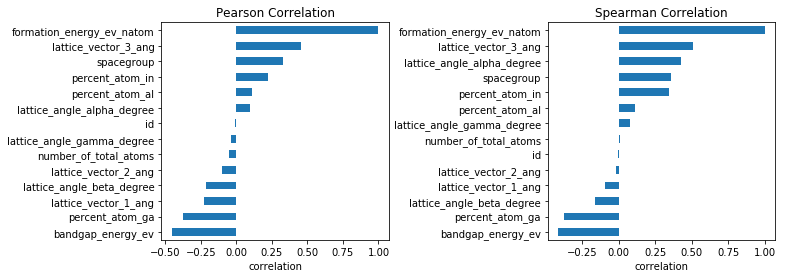

In [6]:
target = 'formation_energy_ev_natom'

plt.figure(1, figsize = (11,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.7, hspace=None)
ax1 = plt.subplot(121)
plt.title('Pearson Correlation')
train.corr()[target].sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('correlation')

ax2 = plt.subplot(122)
plt.title('Spearman Correlation')
train.corr(method = 'spearman')[target].sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('correlation')

There are a couple of siginificant takeaways from these plots: 
   
- formation energy and bandgap energy are strongly negatively correlated
- high pearson correlation witnessed between some features and formation energy implies that they have a significant linear relationship. 
    
We can do this same analysis with the other output variable, bandgap energy:

Text(0.5,0,'correlation')

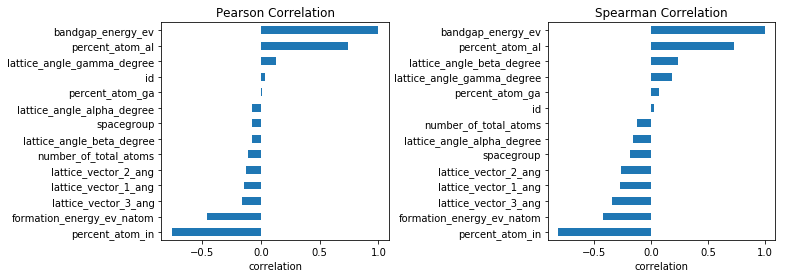

In [7]:
target = 'bandgap_energy_ev'

plt.figure(1, figsize = (11,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.7, hspace=None)
ax1 = plt.subplot(121)
plt.title('Pearson Correlation')
train.corr()[target].sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('correlation')

ax2 = plt.subplot(122)
plt.title('Spearman Correlation')
train.corr(method = 'spearman')[target].sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('correlation')

The correlation between features and bandgap energy do not seem as strong as with formation energy, escpecially the pearson correlation. This means that the linear relationship between features and bandgap energy is weaker than with formation energy. Consequently finding a model to properly fit this output variable may not be as simple as with formation energy however, this should not be a big issue since we are using boosting models. It is now time to take a look at the correlations between input variables in the dataset:

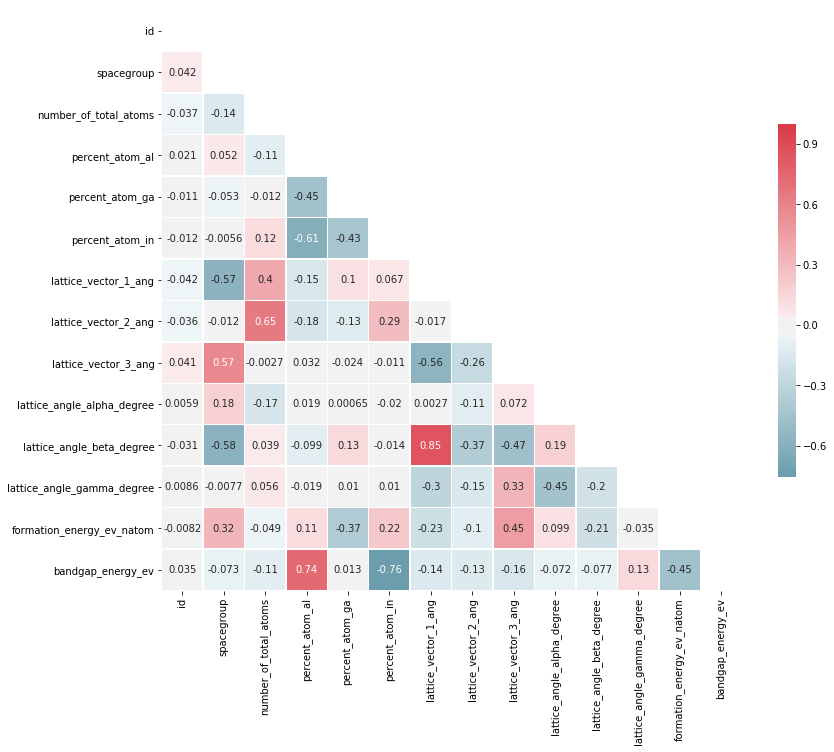

In [8]:
corr = train.corr(method = 'pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (13, 13))
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

The plot above shows the correlation for every feature with every other feature. Red blocks indicate high correlation while blue blocks indiciate very negative correlations. I usually tag any correlation as high if it's absolute value is over 0.5 for pearson correlation and over 0.3 for spearman correlation. You can see that there is a significant amount of multicollinearity going on between a couple of features which should be dealt with. Despite this, since this is the first run-through we'll keep the mutlicollinear features and deal with them at a later time.

<a id=’Outlier_Detection’></a>
## 1.2 Outlier Detection

Now that we've had a chance to check for correlations among features, the next step is to hunt for outliers in each respective feature. This can be done by making boxplots for every feature. Any points outside of the      can be considered outliers:

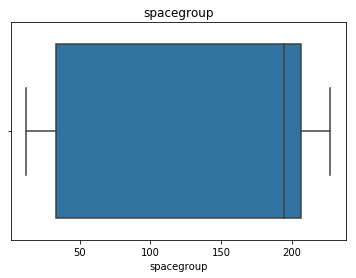

In [9]:
feature = 'spacegroup'
plt.title(feature)
sns.boxplot(x=train[feature])

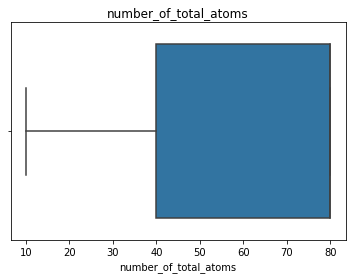

In [10]:
feature = 'number_of_total_atoms'
plt.title(feature)
sns.boxplot(x=train[feature])

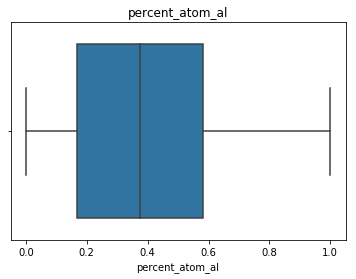

In [11]:
feature = 'percent_atom_al'
plt.title(feature)
sns.boxplot(x=train[feature])

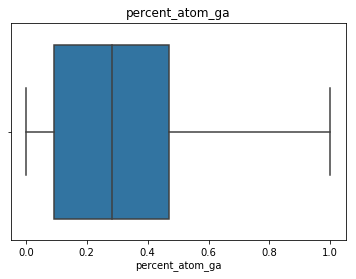

In [12]:
feature = 'percent_atom_ga'
plt.title(feature)
sns.boxplot(x=train[feature])

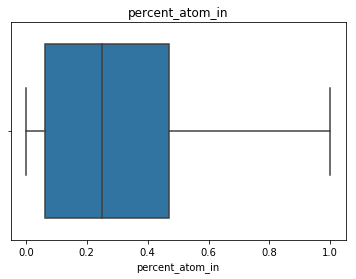

In [13]:
feature = 'percent_atom_in'
plt.title(feature)
sns.boxplot(x=train[feature])

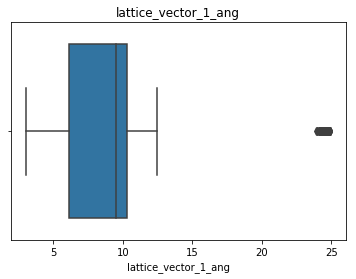

In [14]:
feature = 'lattice_vector_1_ang'
plt.title(feature)
sns.boxplot(x=train[feature])

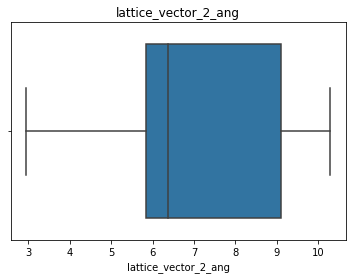

In [15]:
feature = 'lattice_vector_2_ang'
plt.title(feature)
sns.boxplot(x=train[feature])

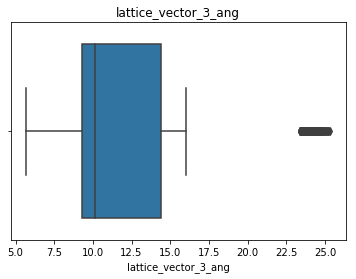

In [16]:
feature = 'lattice_vector_3_ang'
plt.title(feature)
sns.boxplot(x=train[feature])

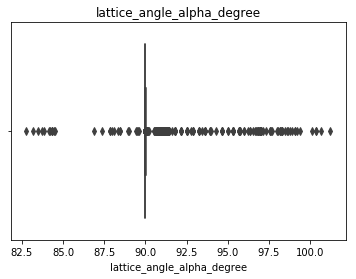

In [17]:
feature = 'lattice_angle_alpha_degree'
plt.title(feature)
sns.boxplot(x=train[feature])

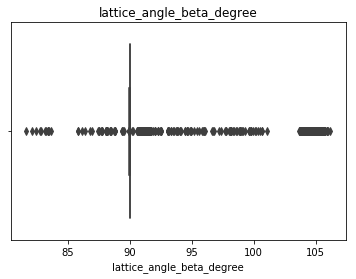

In [18]:
feature = 'lattice_angle_beta_degree'
plt.title(feature)
sns.boxplot(x=train[feature])

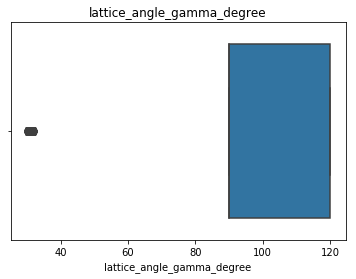

In [19]:
feature = 'lattice_angle_gamma_degree'
plt.title(feature)
sns.boxplot(x=train[feature])

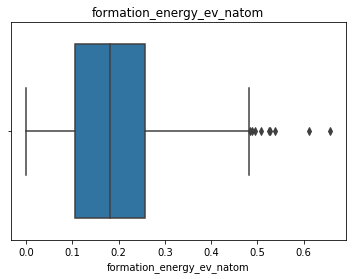

In [20]:
feature = 'formation_energy_ev_natom'
plt.title(feature)
sns.boxplot(x=train[feature])

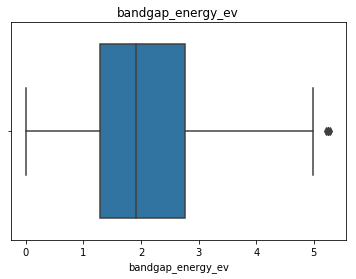

In [21]:
feature = 'bandgap_energy_ev'
plt.title(feature)
sns.boxplot(x=train[feature])

It is evident that many of the features contain a least a *few* outliers. Because this project is only using boosting methods, this may not be a huge issue so for the first run-through outliers will not be altered or removed from the dataset. 

<a id=’Evaluation_Metric’></a>
## 2. Evaluation Metric

For this competiton Kaggle is using the root mean squared logarithmic error to evaluate the success of a model. There isn't any built-in function in python to calculate this, but we can easily write our own:

In [22]:
def rmsle(y, y_pred): 
    """
    Compute the Root Mean Squared Log Error for hypthesis y_pred and targets y

    Args:
        y_pred - numpy array containing predictions with shape (n_samples, n_targets)
        y      - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(       np.mean(np.square(np.log(y_pred + 1) - np.log(y + 1)))         );

Now that we've done our EDA and written a function to evaluate the success of model we can move onto the fun part of trying different models. The first one we'll try will be good ol'e reliable XGBoost:

<a id=’XGBoost’></a>
## 3. XGBoost

We start by importing the proper packages:

In [23]:
from xgboost import XGBRegressor

/Users/am2786/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

<a id=’Train_Test_split’></a>
## 3.1 Train-Test split

Now the data must be split into a training and test set:

In [25]:
X = train.drop(['id', 'bandgap_energy_ev', 'formation_energy_ev_natom'], axis = 1)
Y = train[['bandgap_energy_ev', 'formation_energy_ev_natom' ]]
Y = np.log(Y + 1)

In [26]:
X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 30)

<a id=’GridSearch_bandgap_energy_ev’></a>
## 3.2 GridSearch bandgap energy

Unlike CatBoost, the success of XGBoost models can vary *greatly* depending on the hyperparamaters chosen. To ensure that the right hyper parameters are chosen, we can do a gridsearch of the hyper-parameter space, then select the best model:

In [28]:
params = {'base_score':[0.2,0.4,0.8],
          'learning_rate':[0.04,0.08,0.16],
          'max_depth':[2,4,8],
          'gamma':[0,0.2,0.4],
          'n_estimators':[50,100,200]}          

The next step is to run the GridSearch over all of the selected hyperparameters, doing a 5-fold cross-validation for each variation of the model:

In [29]:
%%time
xgb = XGBRegressor()
grid = GridSearchCV(estimator=xgb,param_grid=params,cv=5,verbose=True,scoring=make_scorer(rmsle,greater_is_better=False))
grid.fit(X_train,Y_train['bandgap_energy_ev'])
y_pred_band = grid.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
CPU times: user 2min 37s, sys: 586 ms, total: 2min 37s
Wall time: 2min 40s


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  2.7min finished


We can check the success of the best model by calculating the root mean square logarithmic error and plotting the actual vs. the predicted values of the output variables in the test set. Starting with bandgap energy first:

Text(0,0.5,'Prediction')

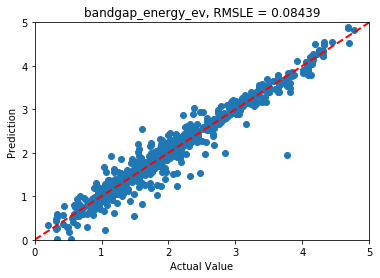

In [30]:
y_test_band_non_log = np.exp(np.array(Y_test['bandgap_energy_ev'])) - 1.
y_pred_band_non_log = np.exp(y_pred_band) - 1.
rmsle_band = rmsle(y_test_band_non_log , y_pred_band_non_log )
rmsle_band = np.round(rmsle_band, 5)
##rmsle_band = rmsle(np.array(Y_test['bandgap_energy_ev']) , y_pred_band )

plt.title('bandgap_energy_ev, RMSLE = %s' %rmsle_band )
plt.scatter(y_pred_band_non_log, y_test_band_non_log)
##plt.scatter(Y_test['bandgap_energy_ev'],  y_pred_band)
plt.plot(np.arange(10), np.arange(10), ls = '--', color = 'r', lw = 2)
plt.axis([0., 5., 0., 5.])
plt.xlabel('Actual Value')
plt.ylabel('Prediction')

This is a pretty decent fit. A perfect model would have all of the datapoints lying on the red-dashed line, which would mean that every prediction was exactly equal to the actual value. The root mean squared logarithmic error is ~ 0.08, which is pretty low. The same evaluation can be done for formation energy:

<a id=’GridSearch_formation_energy_ev_natom’></a>
## 3.3 GridSearch formation energy

Just as before the first step is to run Gridsearch over the selected parameter space:

In [31]:
%%time
xgbb = XGBRegressor()
gridd = GridSearchCV(estimator=xgbb,param_grid=params,cv=5,verbose=True,scoring=make_scorer(rmsle,greater_is_better=False))
gridd.fit(X_train,Y_train['formation_energy_ev_natom'])
y_pred_form = gridd.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  2.6min finished


CPU times: user 2min 31s, sys: 491 ms, total: 2min 32s
Wall time: 2min 33s


Looking at the root mean squared logarithmic error and plotting the actual vs. predicted values for formation_energy:

Text(0,0.5,'Prediction')

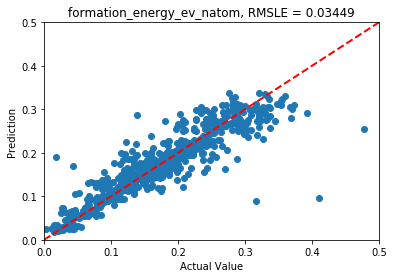

In [32]:
y_test_form_non_log = np.exp(np.array(Y_test['formation_energy_ev_natom'])) - 1.
y_pred_form_non_log = np.exp(y_pred_form) - 1.
rmsle_form = rmsle(y_test_form_non_log , y_pred_form_non_log )
rmsle_form = np.round(rmsle_form, 5)

plt.title('formation_energy_ev_natom, RMSLE = %s' %rmsle_form )
plt.scatter(Y_test['formation_energy_ev_natom'], y_pred_form)
plt.plot(np.arange(10), np.arange(10), ls = '--', color = 'r', lw = 2)
plt.axis([0., 0.5, 0., 0.5])
plt.xlabel('Actual Value')
plt.ylabel('Prediction')

The root mean squared logrithmic error is even lower for formation_energy. From the plot it also seems that the model can predict low values more accurately than larger values. 

<a id=’XGBoost_Results’></a>
## 3.4 XGBoost Results

Since we have 2 output variables, we can take the mean of the two to asses the overall success of XGBoost on this dataset. It should be noted that the specific set of hyperparameters which optimized the loss function (in this case root mean squared error) for the 2 output variable may be different from each other. This is not in any way an issue, but it will be something to look into later as it may shed insight into finding an even better set of hyperparameters. 

In [33]:
print ("XGBoost root mean square logarithmic error =", ((rmsle_form + rmsle_band)/2.))

XGBoost root mean square logarithmic error = 0.05944


## 4. CatBoost

First let's import the CatBoost package:

In [34]:
from catboost import CatBoostRegressor

<a id=’Train_Test_split2’></a>
## 4.1 Train-Test split

Now a train-test split:

In [35]:
X = train.drop(['id', 'bandgap_energy_ev', 'formation_energy_ev_natom'], axis = 1)
Y = train[['bandgap_energy_ev', 'formation_energy_ev_natom' ]]
Y = np.log(Y + 1)

In [36]:
X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 30)

<a id=’GridSearch_bandgap_energy_ev2’></a>
## 4.2 GridSearch bandgap energy 

Now the appeal of CatBoost is that it is effective without having to tune any hyperparameters. Nonetheless, we'll do a gridsearch for bandgap energy:

In [37]:
catboost = CatBoostRegressor(loss_function='RMSE',
                            eval_metric='RMSE',
                            od_type='Iter',
                            od_wait=50)

In [39]:
params = {'iterations':[500, 1200, 2000],
          'learning_rate':[0.03,0.08,0.16],
          'depth':[2,4,8],
          'l2_leaf_reg':[0,10,20]}


Implementing a 5-fold cross-validation on the grid search:

In [41]:
%%time

grid = GridSearchCV(estimator=catboost,param_grid=params,cv=5,verbose=True,
                    scoring=make_scorer(rmsle,greater_is_better=False))
grid.fit(X_train,Y_train['bandgap_energy_ev'])
y_pred_band = grid.predict(X_test)
rmsle_band = rmsle(np.array(Y_test['bandgap_energy_ev']), y_pred_band)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
CPU times: user 1min 43s, sys: 718 ms, total: 1min 44s
Wall time: 1min 52s


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  1.9min finished


We can now look at the actual vs. predicted values, as well as the root mean squared logarithmic error:

Text(0,0.5,'Prediction')

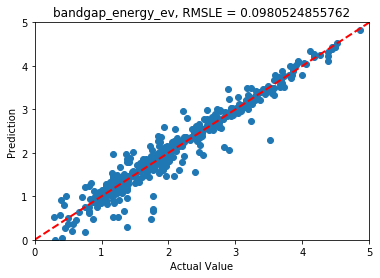

In [43]:
plt.title('bandgap_energy_ev, RMSLE = %s' %rmsle_band )
plt.scatter(y_pred_band_non_log, y_test_band_non_log)
plt.plot(np.arange(10), np.arange(10), ls = '--', color = 'r', lw = 2)
plt.axis([0., 5., 0., 5.])
plt.xlabel('Actual Value')
plt.ylabel('Prediction')

The predicted values are pretty accurate, but CatBoost has performed worse on predicting bandgap energy than XGBoost.

<a id=’GridSearch_formation_energy_ev_natom2’></a>
## 4.3 GridSearch formation energy

Doing the same gridsearch on formation energy:

In [44]:
%%time

grid = GridSearchCV(estimator=catboost,param_grid=params,cv=5,verbose=True,
                    scoring=make_scorer(rmsle,greater_is_better=False))
grid.fit(X_train,Y_train['formation_energy_ev_natom'])
y_pred_form = grid.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  1.8min finished


CPU times: user 1min 45s, sys: 874 ms, total: 1min 46s
Wall time: 1min 49s


Calculating the root mean square logarithmic error:

In [45]:
y_test_form_non_log = np.exp(np.array(Y_test['formation_energy_ev_natom'])) - 1.
y_pred_form_non_log = np.exp(y_pred_form) - 1.
rmsle_form = rmsle(y_test_form_non_log , y_pred_form_non_log )


Plotting the actual vs. predicted values:

Text(0,0.5,'Prediction')

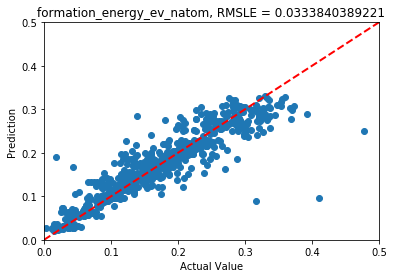

In [48]:
plt.title('formation_energy_ev_natom, RMSLE = %s' %rmsle_form )
plt.scatter(Y_test['formation_energy_ev_natom'], y_pred_form)
plt.plot(np.arange(10), np.arange(10), ls = '--', color = 'r', lw = 2)
plt.axis([0., 0.5, 0., 0.5])
plt.xlabel('Actual Value')
plt.ylabel('Prediction')

CatBoost performs better on formation energy than XGBoost. 

<a id=’CatBoost_Results’></a>
## 4.4 CatBoost Results

In [49]:
print ("CatBoost root mean square logarithmic error =", ((rmsle_form + rmsle_band)/2.))

CatBoost root mean square logarithmic error = 0.0657182622492


<a id=’Summary’></a>
## 5. Summary and Future work

So we can summarize what we've done as such:

- Conducted exploratory data analysis on dataset
- Assessed effectiveness of XGBoost by using 5-fold cross validation and gridsearch on dataset
- Assessed effectiveness of CatBoost by using 5-fold cross validation and gridsearch on dataset

We can summarize the effectiveness of each model by plotting the root mean logarithmic sqaure for both models and both output variables:

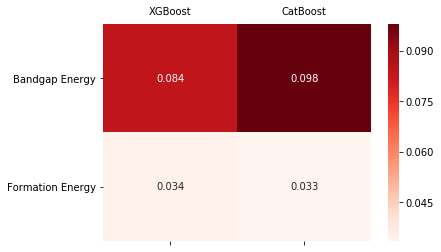

In [78]:
final_info = np.array([[0.08439,0.03449],[rmsle_band,rmsle_form]]).T
sns.heatmap(final_info, cmap = plt.cm.Reds, annot = True)
plt.xticks([0.5,1.5], ['XGBoost', 'CatBoost'])
plt.yticks([0.5,1.5], ['Bandgap Energy', 'Formation Energy'], rotation=0)
#plt.xaxis.set_ticks_position('top')
plt.tick_params(labelbottom='off',labeltop='on')

The color in each square corresponds to the root mean square logarithmic error for that respective model and target feature. XGBoost works better overall than CatBoost with the specific parameters chosen. Both models are relatively effective at predicting formation energy but XGBoost has been more effective at predicting bandgap energy than CatBoost. Both models seem to be more effective at predicting higher values of bandgap energy. Moving forward steps that can be taken to improve the model further are:

- Toss out outliers or set their values to 1st and 99th percentile thresholds 
- Standardize features
- Explore parameter space more deeply during GridSearch